# Section 6: Spectral Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rc, rcParams
from collections import namedtuple
import warnings 
warnings.filterwarnings("ignore")
rc('text',usetex=True)
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=3, pad=3)
rc('xtick', labelsize=13)
rc('ytick.major', size=3, pad=3)
rc('ytick', labelsize=13)

In [2]:
#Defining our own median function 
def median(arr):
    sortedArr = sorted(arr)
    if len(sortedArr) % 2 == 1:
        return sortedArr[int(len(sortedArr) / 2)]
    else:
        return (sortedArr[int(len(sortedArr) / 2)]/2 + sortedArr[int(len(sortedArr) / 2 - 1)]/2)
    
    
#MUST USE (so we don't use np.median)
def special_median(data):
    color_pixels = np.transpose([frame.flatten() for frame in data])
    medians = [median(pixel) for pixel in color_pixels] 
    master_data = np.reshape(medians, np.shape(data[0])) 
    return master_data

In [3]:
def centroid(arr, bounds=None): # returns the centroid index for an array with optional bounds for computing the centroid
    offset = 0
    
    if not(bounds is None): # slices the array to fit the bounds
        arr = arr[bounds[0]:bounds[1]]
        offset = bounds[0]
    
    centroid = sum(range(len(arr)) * arr) / sum(arr) + offset
    error = sum(((np.array(range(len(arr))) - (centroid - offset)) ** 2) * arr) / sum(arr)
    
    return centroid, error

def leastSquaresFit(x, y): # computes the slope and intercept of a least squares regression line fitting the input data
    if len(x) != len(y): # raises an error if the arrays are not the same length
        raise ValueError('x and y must be the same size')
    else:
        # named tuples to be returned
        Parameters = namedtuple('Parameters', ['m', 'b'])
        Errors = namedtuple('Errors', ['dm', 'db'])
        
        # Construct the matrices
        ma = np.array([[np.sum(x**2), np.sum(x)], [np.sum(x), len(x)]])
        mc = np.array([[np.sum(x*y)], [np.sum(y)]])

        # Compute the gradient and intercept
        mai = np.linalg.inv(ma) # inverts matrix ma
        md = np.dot(mai,mc) # matrix multiply is dot

        # error propagation using formulae in lab manual (page 7)
        sigma = np.sqrt(np.sum((y - (md[0,0] * x + md[1,0])) ** 2) / (len(x) - 2))
        sigmam = np.sqrt(len(x) * sigma ** 2 / (len(x)*np.sum(x**2) - np.sum(x)**2))
        sigmab = np.sqrt((sigma**2) * np.sum(x**2) / (len(x)*np.sum(x**2) - np.sum(x)**2))

        # construct tuples
        params = Parameters(md[0,0], md[1,0])
        errs = Errors(sigmam, sigmab)

        return params, errs

In [4]:
# The end-all, be-all of centroid functions. It slices. It dices. It cuts. Ladies and gents, nCentroids does it all.
def nCentroids(arr, n=None, bounds=None, background=None, nsigma=10, cutoff=None): # returns a 1xn array of centroid indices
    if not(n is None) and n < 1: # n is the number of peaks to centroid, so if specified, it must be at least 1
        raise ValueError('n must be greater than or equal to 1')

    offset = 0
    if not(bounds is None): # resizes the array to only the values within the bounds while saving an offset to add to the final centroids
        arr = arr[bounds[0]:bounds[1]]
        offset = bounds[0]

    crosses = [] # to save the indices where arr crasses above or below the div or cutoff
    if (background is None and cutoff is None) or not(n is None): # this if-block to run when n is specified or when nothing is
        if not(background is None and cutoff is None): # prioritize the right number of peaks over using a background noise
            warn('background and cutoff are ignored when n is provided')
        
        # if n is unspecified at this point, then neither are background or cutoff, so we need some criteria to isolate peaks
        # by default, we find the centroid for the 1 largest peak
        if n is None: 
            n = 1
        
        div = (np.max(arr) + np.min(arr)) / 2 # sets divider at the midpoint of the data
        lastDiv = None
        peaks = 0
        while peaks != n:
            divArr = arr - div
            crosses = np.where(np.diff(np.sign(divArr)))[0] # identifies indices where arr goes from < to > div or vice versa
            if (len(crosses) % 2 != 0): # if it crosses an uneven number of times, the bounds may not fully contain a peak
                raise RuntimeError('the number of peaks could not be resolved within the bounds of arr')

            temp = div
            peaks = int(len(crosses) / 2) # What goes up must come down. For every peak there are 2 crosses of div
            # adjust div up or down according to whether there are too many or too few peaks above div
            if peaks < n:
                if lastDiv is None:
                    div -= abs(div - np.min(arr)) / 2
                else:
                    div -= abs(div - lastDiv) / 2
            elif peaks > n:
                if lastDiv is None:
                    div += abs(div + np.min(arr)) / 2
                else:
                    div += abs(div + lastDiv) / 2
            lastDiv = temp
    else: # occurs when using a cutoff or background to identify peaks
        if not(background is None) and not(cutoff is None):
            warn('background is ignored when cutoff is provided') # priority of use: n > cutoff > background
        if cutoff is None: # sets a cutoff based on the standard deviation and mean of the background and nsigma
            cutoff = nsigma*np.std(background) + np.mean(background) 
        divArr = arr - cutoff
        crosses = np.where(np.diff(np.sign(divArr)))[0] # identifies indices where arr goes from < to > cutoff or vice versa
        
    subBounds = np.array(np.reshape(crosses, (int(len(crosses)/2), 2))) # uses crosses as paired upper and lower bounds for centroids
    for i, abounds in enumerate(subBounds): # expands the bounds to make sure the full width of the peak is considered to determie centroid
        width = abs(abounds[0] - abounds[1])
        if i > 0:
            subBounds[i][0] = max(abounds[0] - width, subBounds[i-1][0]) # max prevents overlap with bounds of another peak
        else:
            subBounds[i][0] = abounds[0] - width
        
        if i < len(subBounds) - 1:
            subBounds[i][1] = min(abounds[1] + width, int((subBounds[i+1][0] + abounds[1])/2)) # min prevents overlap with bounds of another peak
        else:
            subBounds[i][1] = abounds[1] + width

    # computes the centroids for arr in each of the bound regions
    centroids = np.array([centroid(arr, abounds)[0] + offset for abounds in subBounds])
    errors = np.array([centroid(arr, abounds)[1] for abounds in subBounds])
    return centroids, errors

# Step 1: Creating a master bias and master dome flat frame

### Getting data for the blue side of the spectrograph (b fits) 

In [5]:
# getting the bias frames for the b fits files 
b_bias_arr = np.arange(101,111)
b_biasfiles = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_bias_arr]
b_biasdata = [fits.getdata(i) for i in b_biasfiles]

# making the master bias frames by taking the median of all bias files
b_masterbias = special_median(b_biasdata) # shape (312,2112)

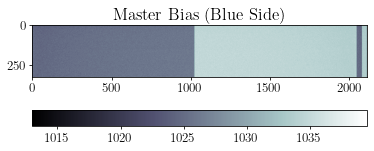

In [6]:
# showing the resulting master bias image
plt.imshow(b_masterbias, cmap='bone')
plt.title('Master Bias (Blue Side)');
plt.colorbar(orientation='horizontal')

In [7]:
b_dome_arr = np.arange(111,151) #This is already cleaned 
name = 'data-2013-10-26-shane-public/b{}.fits'
fnames = [name.format(i+1) for i in b_dome_arr] 
expTimes = [fits.open(i)[0].header['EXPTIME'] for i in fnames]
[print(expTimes[i], b_dome_arr[i]) for i in range(len(b_dome_arr))][0] 

60.0 111
60.0 112
60.0 113
60.0 114
60.0 115
60.0 116
60.0 117
60.0 118
60.0 119
90.0 120
90.0 121
90.0 122
90.0 123
90.0 124
90.0 125
90.0 126
90.0 127
90.0 128
90.0 129
90.0 130
90.0 131
90.0 132
90.0 133
90.0 134
90.0 135
90.0 136
90.0 137
90.0 138
90.0 139
90.0 140
90.0 141
90.0 142
90.0 143
90.0 144
90.0 145
90.0 146
90.0 147
90.0 148
90.0 149
1200.0 150


In [8]:
b_dome_arr60 = np.arange(111,120)
b_dome_arr90 = np.arange(120,150)
b_dome_arr1200 = [1200]

b_dome_arr = b_dome_arr90

b_domefiles = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_dome_arr]
b_domedata = [fits.getdata(i) for i in b_domefiles]

# making the masterdome based on the median of all dome flat data 
b_masterdome = special_median(b_domedata) 

# bias subtracting and normalizing the dome flat
b_norm_flat = (b_masterdome-b_masterbias)/special_median((b_masterdome - b_masterbias))
b_norm_flat[b_norm_flat < 0] = 0

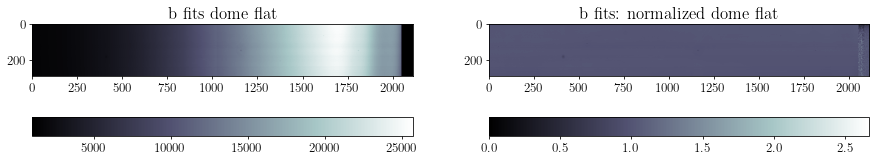

In [9]:
# good news : this basically looks the same as the individual dome flats... source trust me bro
fig, ax = plt.subplots(1,2,figsize=(15,5))

b_im1 = ax[0].imshow(b_masterdome[10:300,:], cmap='bone')
ax[0].set_title('b fits dome flat');
b_cbar1 = fig.colorbar(b_im1, ax=ax[0], orientation='horizontal')

b_im2 = ax[1].imshow(b_norm_flat[10:300,:], cmap='bone')
ax[1].set_title('b fits: normalized dome flat');
b_cbar2 = fig.colorbar(b_im2, ax=ax[1], orientation='horizontal')

# 



# Step 2: Bias subtraction from all data 
This includes the dome flat, arclamp, and science objects. 

### Arc Lamp for Blue

In [10]:
b_arcdata = fits.getdata('data-2013-10-26-shane-public/b100.fits')
b_corrected_arc = (b_arcdata - b_masterbias) / b_norm_flat

b_corrected_arc[b_corrected_arc == -np.inf] = 0
b_corrected_arc[b_corrected_arc == np.inf] = 0
b_corrected_arc[b_corrected_arc == np.nan] = 0
b_corrected_arc[b_corrected_arc < 0] = 0

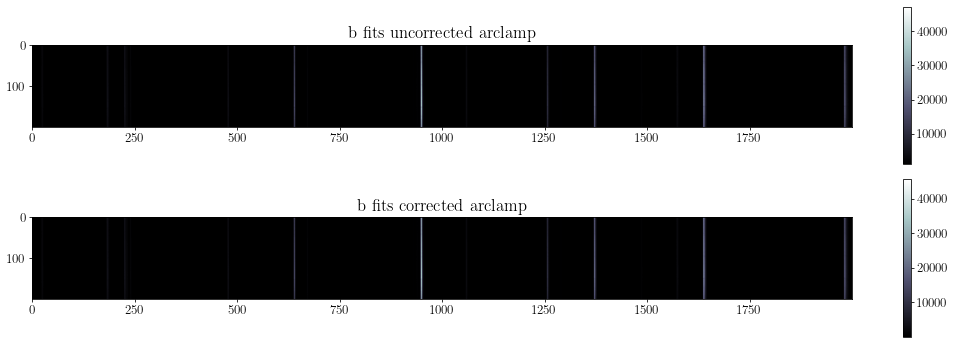

In [11]:
fig, ax = plt.subplots(2,1,figsize=(15,5))
arc_b_im1 = ax[0].imshow(b_arcdata[100:300,0:2000], cmap='bone')
arc_b_im2 = ax[1].imshow(b_corrected_arc[100:300,0:2000], cmap='bone')

arc_b_cbar1 = fig.colorbar(arc_b_im1, ax=ax[0], orientation='vertical')
arc_b_cbar1 = fig.colorbar(arc_b_im2, ax=ax[1], orientation='vertical')
ax[0].set_title('b fits uncorrected arclamp');
ax[1].set_title('b fits corrected arclamp');
fig.tight_layout()

### Arc Lamp Spectra

(array([-2000000.,        0.,  2000000.,  4000000.,  6000000.,  8000000.,
        10000000., 12000000., 14000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

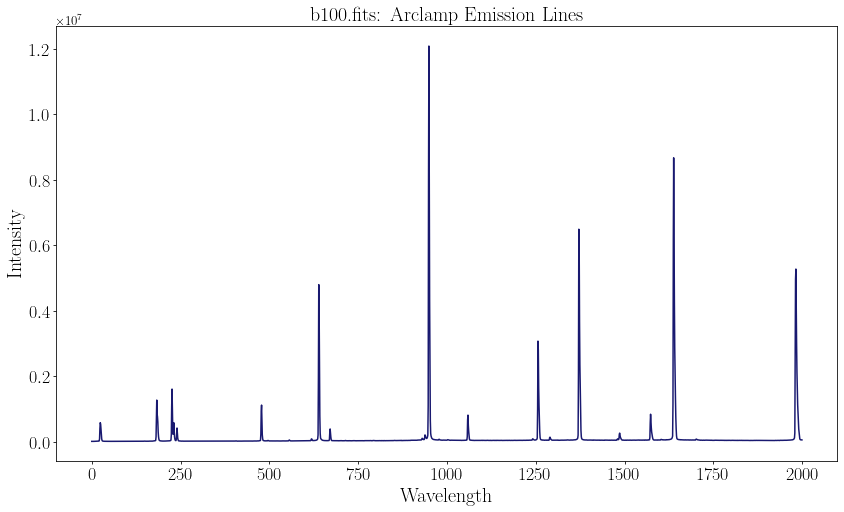

In [12]:
# plotting the arclamp spectra
# There is only one for the blue
plt.figure(figsize=(14,8))
plt.plot(np.sum(b_corrected_arc,axis=0)[:2000], color='midnightblue');
plt.title('b100.fits: Arclamp Emission Lines', fontsize = 20)
plt.xlabel('Wavelength', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [13]:
# KAST calibration arclamp spectra - blue 452/3306 grism
yArc = np.array([326.105,340.365,346.655,361.051,365.015,388.865,404.656,407.783,435.833,447.150,467.816,479.992,
              492.193,501.568,508.582,546.074,576.959,579.065,587.562]) 
xArc, errArc = nCentroids(np.sum(b_corrected_arc,axis=0)[0:2000],19)

In [14]:
params, errs = leastSquaresFit(xArc, yArc) # compute the fit parameters and errors
m, b = params
dm, db = errs

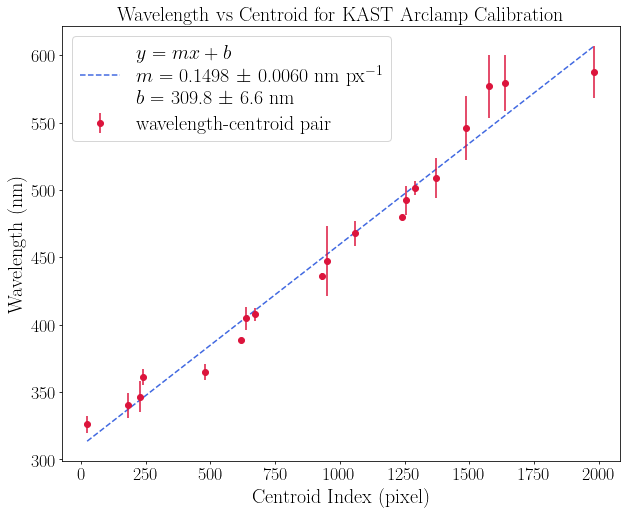

In [15]:
# plot centroid-wavelength pairs for each element, color-coded with the lamp's appearance
plt.figure(figsize=(10,8))
plt.errorbar(xArc, yArc,yerr=errArc, fmt='o', color='crimson', label='wavelength-centroid pair')

# plot the least squares fit line
# x = np.arange(xAll.min(), xAll.max(), dtype=float) # I have to do this because the line style doesn't work without it for some indiscernable reason
plt.plot(xArc, m*xArc + b, '--', color = 'royalblue', 
         label=('$y = mx + b$\n$m$ = %.4f $\pm$ %.4f nm px$^{-1}$\n$b$ = %.1f $\pm$ %.1f nm' % (m, dm, b, db)), zorder=0) 

# labeling
plt.title('Wavelength vs Centroid for KAST Arclamp Calibration', fontsize=20)
plt.xlabel('Centroid Index (pixel)', fontsize=20)
plt.ylabel('Wavelength (nm)', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

(array([-2000000.,        0.,  2000000.,  4000000.,  6000000.,  8000000.,
        10000000., 12000000., 14000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

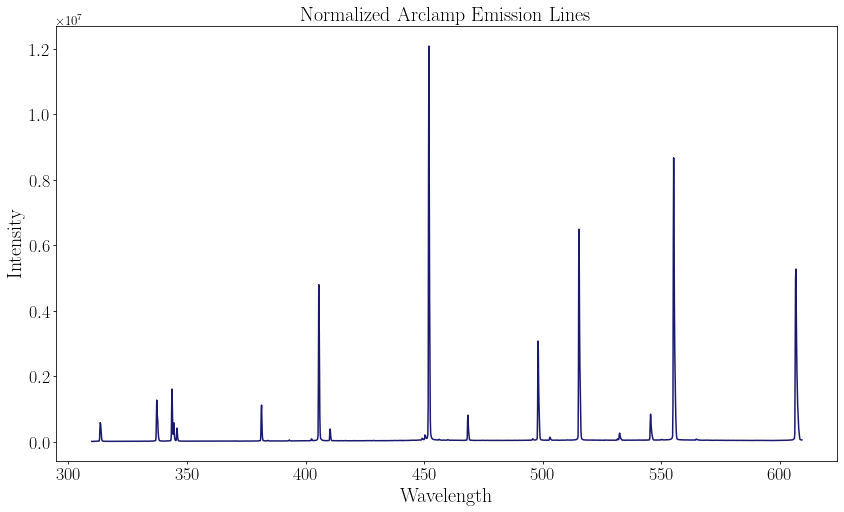

In [16]:
# plotting the arclamp spectra for blue
w_len = nCentroids(np.sum(b_corrected_arc,axis=0)[0:2000],19)[0]*m+b
wave = np.arange(0,2000)
plt.figure(figsize=(14,8))
plt.plot(m*wave + b,np.sum(b_corrected_arc,axis=0)[:2000], color='midnightblue')
plt.title('Normalized Arclamp Emission Lines', fontsize = 20)
plt.xlabel('Wavelength', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

### Blue Science Objects

In [17]:
b_science_arr = np.arange(151,161)
b_scifile = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_science_arr]
b_sciencedata = [fits.getdata(i) for i in b_scifile]
b_sci_names = [fits.open(i)[0].header['OBJECT'] for i in b_scifile]

# subtracting the bias from the science objects 
b_corrected_science = [ (b_sciencedata[i] - b_masterbias) / b_norm_flat for i in range(len(b_sciencedata))]
b_corrected_science = [np.nan_to_num(data, nan=0, posinf=0, neginf=0) for data in b_corrected_science]

# replace negative values with 0
for i in range(len(b_corrected_science)):
    b_corrected_science[i][b_corrected_science[i] < 0] = 0

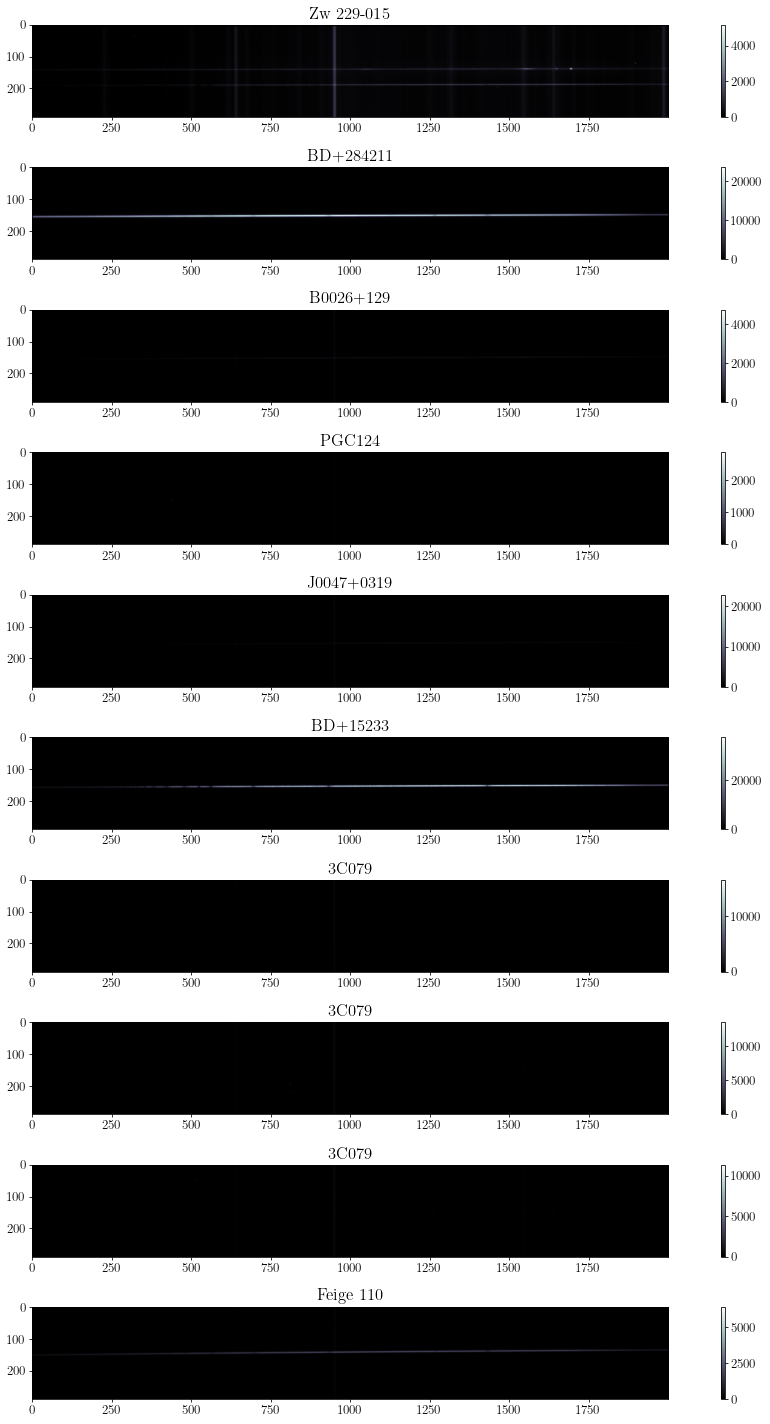

In [18]:
# plot of corrected science objects 
fig, ax = plt.subplots(10,1, figsize=(15,20))

for i in range(len(b_corrected_science)):
    temp = ax[i].imshow(b_corrected_science[i][10:300,0:2000], cmap='bone')
    ax[i].set_title(b_sci_names[i])
    colorbar = fig.colorbar(temp, ax=ax[i], orientation='vertical')
    fig.tight_layout()

## Looking at 2 Sources

## B0026+129

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

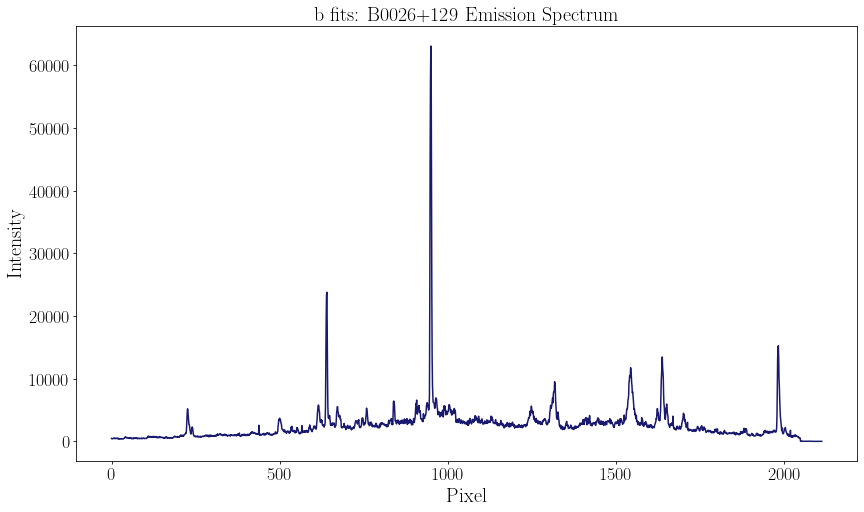

In [19]:
plt.figure(figsize=(14,8))
plt.plot(np.sum(b_corrected_science[2],axis=0), color='midnightblue');
plt.xlabel('Pixel', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)
plt.title(f'b fits: {b_sci_names[2]} Emission Spectrum', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

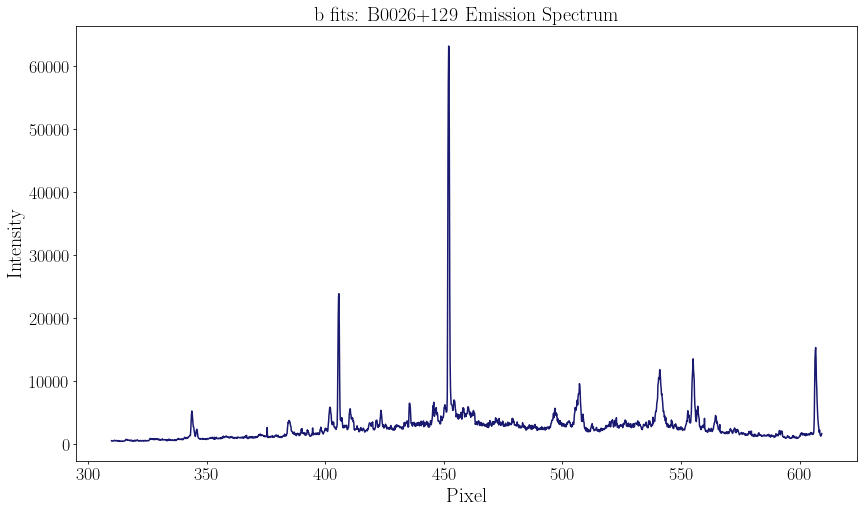

In [20]:
# nCentroids(np.sum(b_corrected_science[2],axis=0)[0:2000],10)*m + b

plt.figure(figsize=(14,8))
plt.plot(m*wave + b, np.sum(b_corrected_science[2],axis=0)[0:2000], color='midnightblue');
plt.xlabel('Pixel', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)
plt.title(f'b fits: {b_sci_names[2]} Emission Spectrum', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

## Zw 229-015

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

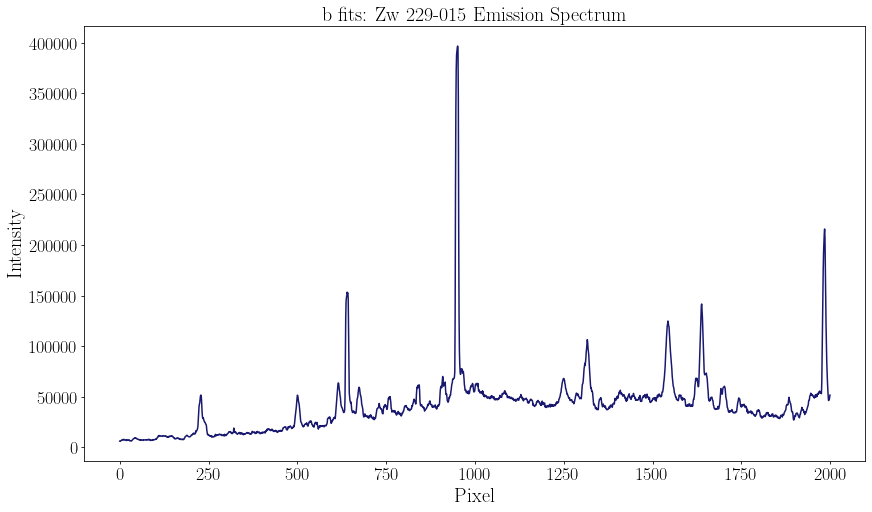

In [21]:
# lab frames, rest wavelengths
plt.figure(figsize=(14,8))
plt.plot(np.sum(b_corrected_science[0],axis=0)[0:2000], color='midnightblue')
plt.xlabel('Pixel', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)
plt.title(f'b fits: {b_sci_names[0]} Emission Spectrum', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

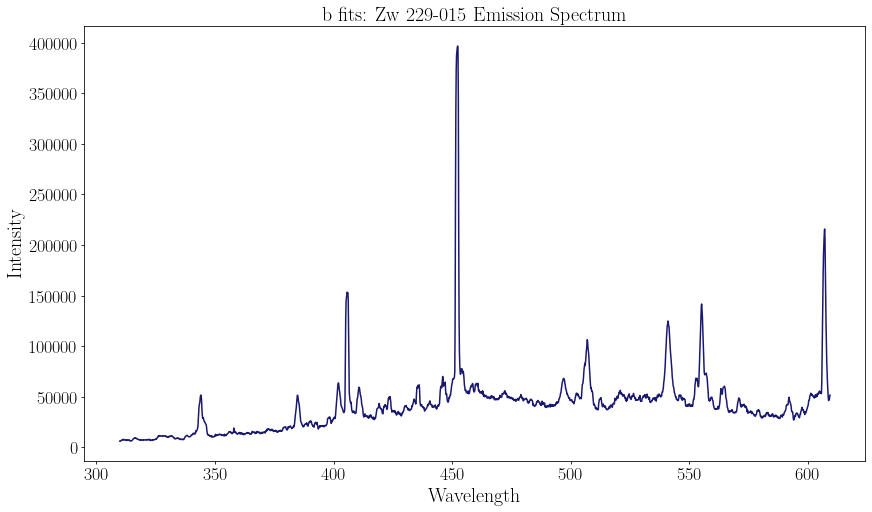

In [22]:
# broadening in the centroid from doppler, rotation
# nCentroids(np.sum(b_corrected_science[0],axis=0)[0:2000],7)*m+b
plt.figure(figsize=(14,8))
plt.plot(m*wave + b, np.sum(b_corrected_science[0],axis=0)[0:2000], color='midnightblue')
plt.xlabel('Wavelength', fontsize = 20)
plt.ylabel('Intensity', fontsize = 20)
plt.title(f'b fits: {b_sci_names[0]} Emission Spectrum', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)